# New York Schools

Over the last three missions, we explored relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

- SAT scores by school: SAT scores for each high school in New York City
- School attendance: Attendance information for each school in New York City
- Class size: Information on class size for each school
- AP test results: Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes: The percentage of students who graduated, and other outcome information
- Demographics: Demographic information for each school
- School survey: Surveys of parents, teachers, and students at each school <br>
<br>
<b>
New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

#the factual datafiles

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
#the survey datafiles
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

If we are to combine all the datasets we need to make sure there is something to join them on, the DBN((district borough number)) will be useful here. <br>
Since some of the datasets either have a different name/term for 'DBN' and some dont have a DBN at all, we will need to create one or edit the name of the column to acheive a common feature between the sets on which to join them.
<br>





In [3]:
#look at demographics
data['demographics'].head(2)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4


In [4]:
#look at class_size
data['class_size'].head(1)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN


Notice Class_size does NOT contain a DBN <br>

However, just From looking at class_size and demographics side by side, we can tell that the DBN in the demographics data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long

In [5]:
#hs_directory does contain DBN just needs capitalizing
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

#function to pad CSD part of the code in harmony with other datasets 
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
#create a DBN for class_size
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

There are many columns within the data which are intended to represent numbers or numerical values but are in the form of a string. We can convert these in order to make comparisons easier.
<br><br>
among them are the 3 seperate sat exam average scores within sat_score for each individual school. It does not make sense to compare on three seperate scores and so we will join them into one universal score.<br><br>
We also need the latitude and longitude in numerical form

In [6]:
#a glimpse of the location information in hs_directory
data["hs_directory"]["Location 1"].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

We can perform an extraction to obtain the lat/lon values within this data

In [7]:
#the columns which need converting
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

#obtain an overall 'sat score' 
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#extract the latitude from hs_directory
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

#extract the latitude from hs_directory
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

#the numerical location data
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In order to join the data we need to make sure each dataset has a unique DBN, else the merges will not know which one row to join on. Some of the datasets have duplicate DBN's which will need to be corrected<br>


In [8]:
data['class_size'].head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015


In [9]:
data['demographics'].head(2)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4


In [10]:
data['graduation'].head(2)

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%


As you can see, the first few rows of class_size all pertain to the same school, which is why the DBN appears more than once. It looks like each school has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT (MS CORE and 9-12 ONLY), and CORE COURSE (MS CORE and 9-12 ONLY).
<br>
<br>
Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.<br>
Each school can have multiple program types. Because GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED

<br>
The only column that prevents a given DBN from being unique in demographics is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.

<br>
In graduation, the Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [11]:
#create unique DBN's for the following datasets
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric
<br>
In ap_2010, there are a few columns which need turning into numerical values

In [12]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets
<br>
Now we can finally combine the sets, we shall do it step by step, and our choice of 'how' to merge will depend on which dataset we are merging with.<br><br>
Both the ap_2010 and the graduation data sets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them. Because we're using a left join, our final dataframe will have all of the same DBN values as the original sat_results dataframe<br><br>
We still have to merge class_size, demographics, survey, and hs_directory into combined. Because these files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type

In [13]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping
<br>
Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

In [23]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

Now we have combined the data we can start to look for interesting patterns within it.

In [24]:
#a correlation series
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [25]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

ValueError: list.remove(x): x not in list

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
len(survey_fields)

22

In [18]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

<b> You can find the various column names and what they represent here
<br>
https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8

## Survey Correlations with Sat Score
<br>
Take a look at how each survey fiel correlates with the sat score

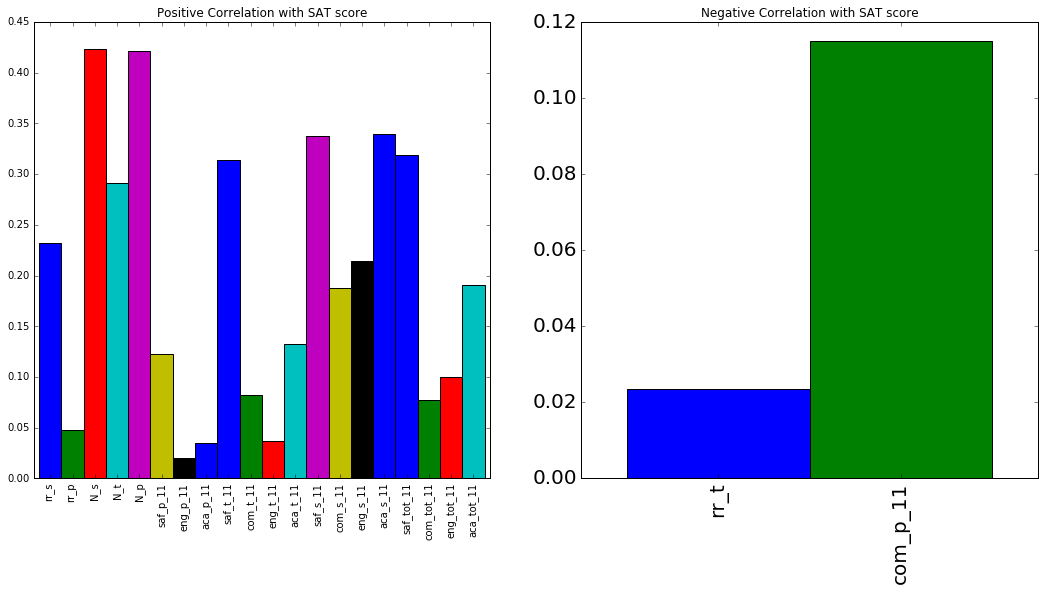

In [16]:
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(2,2,1)
ax1 = above_eq_zero.plot(kind='bar', fontsize=10,width=1)
ax1.set_title('Positive Correlation with SAT score')
ax2 = fig.add_subplot(2,2,2)
ax2 = less_zero_abs_val.plot(kind='bar', width=1, fontsize=20)
ax2.set_title('Negative Correlation with SAT score')
plt.show()

In [19]:
survey_corr = correlations[survey_fields]
above_eq_zero = survey_corr[survey_corr >= 0]
less_zero = survey_corr[survey_corr < 0]
less_zero_abs_val = abs(less_zero)


It seems the more parents, teachers and students whom took part in the survey from a school, the greater the SAT score of the school. Perhaps this is due to the fact that participating in the survey indicates interest in the students learning/development, which might carry over to academic acheivement. 

Interestingly there seems to be little to no relation between SCORE and response rate (percentage) from parents or teachers, which doesn't add up with the above findings. Response rate from students however does relate to the above.

When assesing engagement, academic expectation and also communication of a given school, it appears students have a better judgement of this than parents and teachers.

Safety is highly correlated with students and teachers alike but less so with parents, perhaps due to the fact that parents spend very little time in the school compared to students/teachers and so therefore cannot assess as accurately.






## Does the Safety of a school indicate the quality

Looking at the above correlation bar chart, it seems the two most important perceptions regarding the safety of the given school (namely teachers and students, whom will be inside the school the majority of the time) are highly connected with the SAT performance. Lets analyze this a little more and see wether it is the case that a 'safer' school performs better.

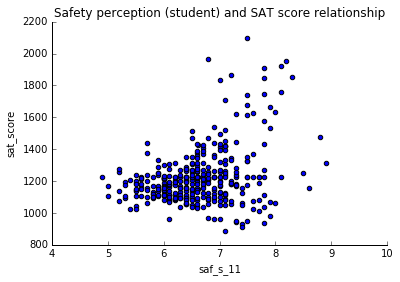

In [20]:
ax = combined.plot(kind='scatter', x='saf_s_11', y='sat_score', title='Safety perception (student) and SAT score relationship')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(top=False, right=False)


The graph doesnt suggest an awfully strong correlation but a correlation none the less. I appears a few high scoring schools with a high perceptive safety rating are accountable for this connection. For the most part, an increase in safety perception doesnt mean an increase in SAT score

### The safest perceived schools by district
<br>
Which schools score highest in safety and in which district?

In [26]:
safety_group = combined.groupby('school_dist').agg(numpy.mean)

In [31]:
#we will only need one of these columns
safety_group.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


In [29]:
safety_by_district = safety_group['saf_tot_11']

In [28]:
from mpl_toolkits.basemap import Basemap

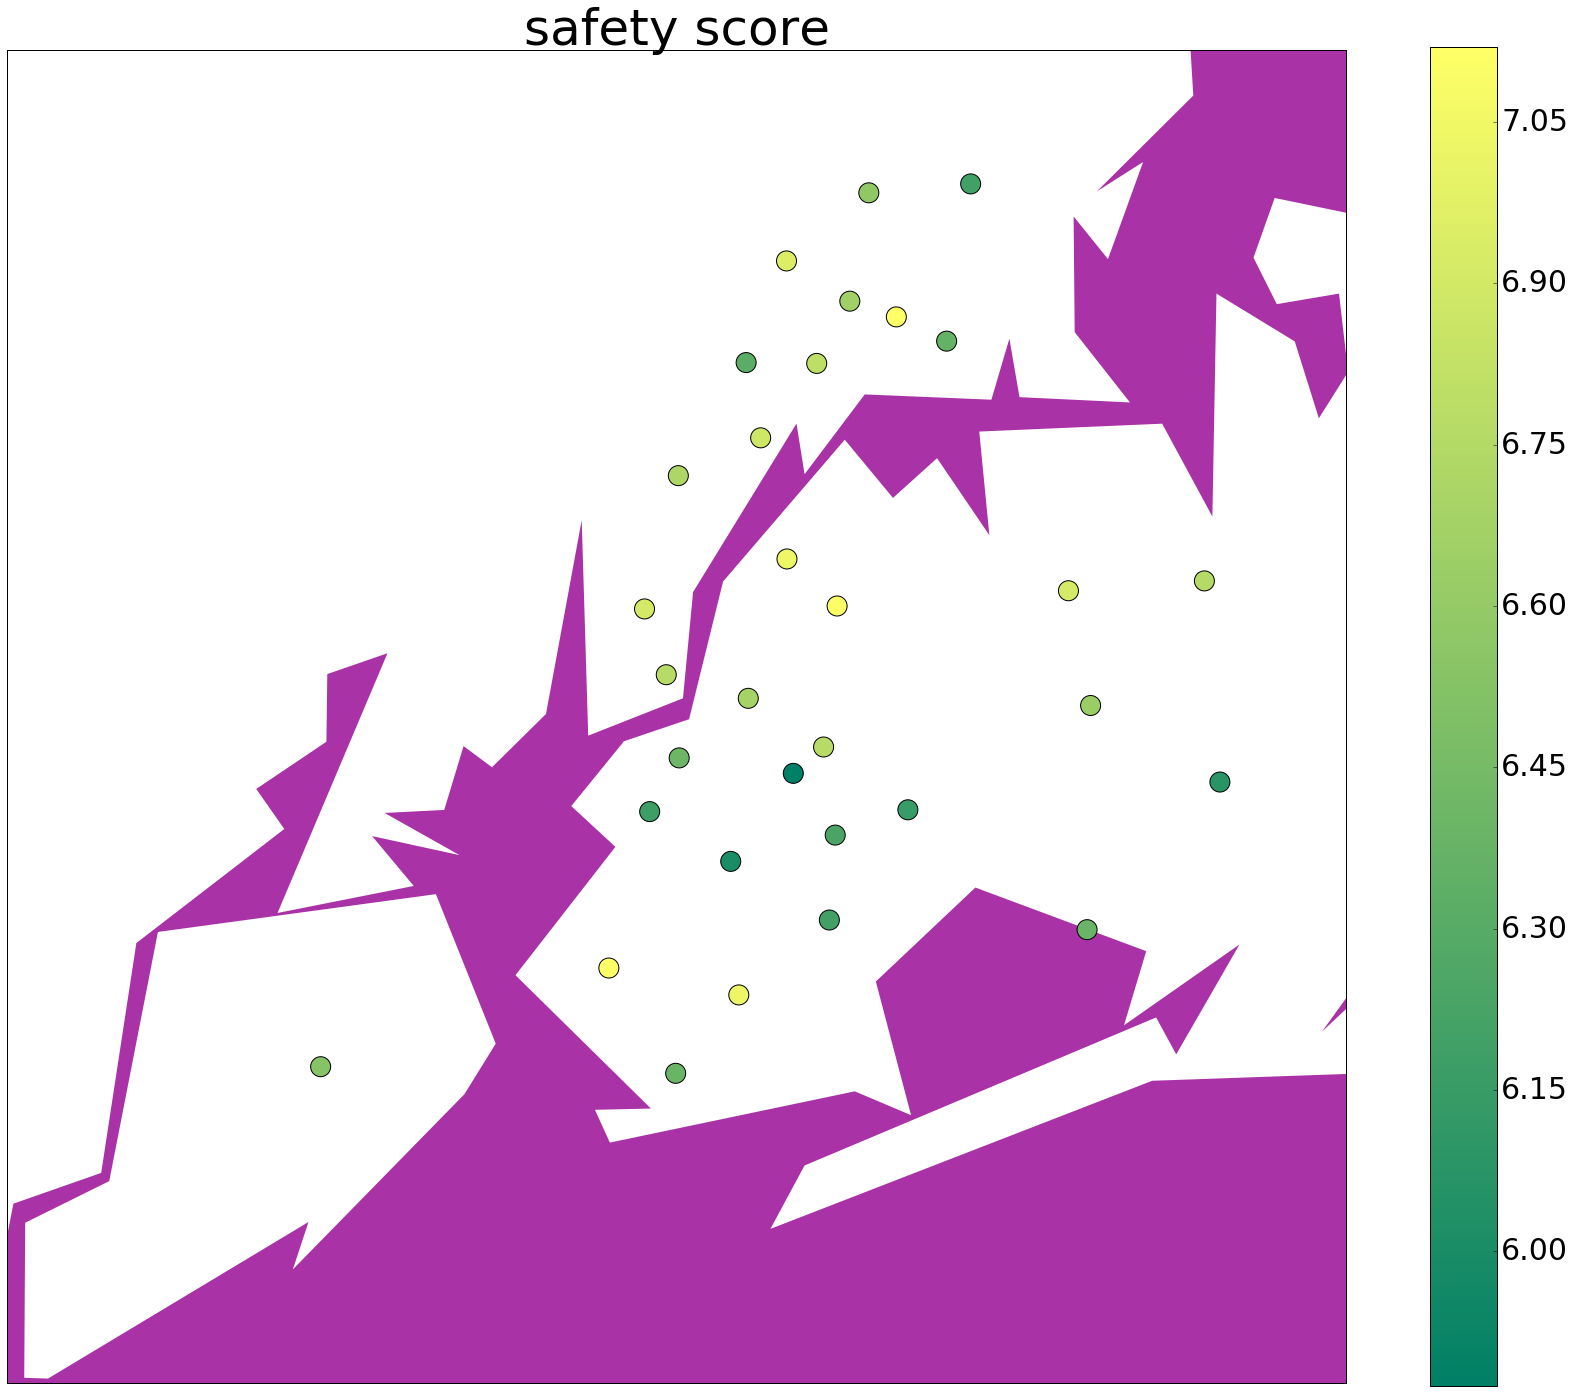

In [39]:
#lets plot a map to visualise these results
from matplotlib import cm
fig, ax = plt.subplots(figsize=(30,30))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i',
)


m.drawmapboundary(fill_color='#a832a6')
m.fillcontinents(color='white',lake_color='#85A6D9')

longi=safety_group['lon'].tolist()
lati = safety_group['lat'].tolist()

im = m.scatter(longi, lati, latlon=True, c=safety_group['saf_s_11'],
          cmap='summer', zorder=2,s=400)
ax.set_title('safety score', size=50)

cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=30)





As the map reveals, it seems like schools in the manhattan and queens areas are percieved to be safer than others. Brooklyn appears to rank very poorly in comparison.


## Racial differences

It may be the case that certain races perform better on the SAT test than others. By looking at the correlation between the SAT score and the percentages of certain racial groups within a given school, we may be able to determine wether this is the case, and if so, try to determine why this is. 

In [40]:
#correlations of seperate races with sat_score
racial_corr = correlations[['white_per', 'asian_per',
                           'black_per','hispanic_per']]


In [41]:
racial_corr

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

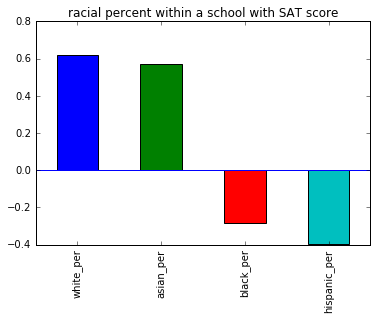

In [42]:
fig, ax = plt.subplots()
ax = racial_corr.plot(kind='bar', title='racial percent within a school with SAT score')
ax.axhline(0)

The bar graph shows that there does seem to be some racial inequality regarding performance on the SAT exams.<b>
It suggests that the higher the percentage of white and asian children within a school, the greater the SAT score and the opposite for black and hispanic.

### Hispanic 

Since the percentage of hispanic students seems to relate to a lower SAT score, lets look into this a little more

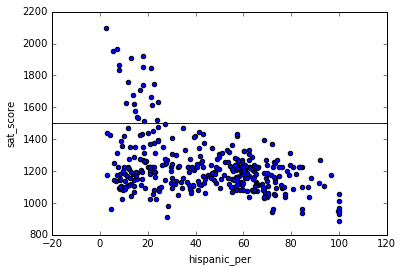

In [43]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')
plt.axhline(1500)


There is a general negative correlation however there are also many schools with a low hispanic population whom perform badly. All schools with a hispanic population above 40% have a SAT score of 1500 or lower.


In [45]:
#the hispanic majority school names
hispanic_majority = combined.loc[combined['hispanic_per'] > 0.5, :]
hispanic_schools = hispanic_majority['SCHOOL NAME']

In [47]:
#rank the schools by sat score 
combo = combined.sort_values('sat_score', ascending=False).copy()
combo = combo.reset_index()
combo['rank_by_sat'] = combo.index.to_series() +1 


In [48]:
hispanic_majority = combo.loc[combo['hispanic_per'] > 50,:]

In [49]:
hispanic_majority[['SCHOOL NAME','ell_percent', 'hispanic_per', 'rank_by_sat']]

,SCHOOL NAME,ell_percent,hispanic_per,rank_by_sat
202,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,19.6,96.7,203
331,MANHATTAN BRIDGES HIGH SCHOOL,72.6,99.8,332
350,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,89.6,99.8,351
352,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,92.9,99.8,353
356,ACADEMY FOR LANGUAGE AND TECHNOLOGY,86.6,99.4,357
357,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,91.3,100.0,358
360,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,79.9,99.8,361
362,MULTICULTURAL HIGH SCHOOL,94.6,99.8,363


In [50]:
combined.shape

(363, 160)

The schools with a high majoirty hispanic population (>95%) in general scored very poorly. As we can see there is a strong positive correlation between the extreme values of hispanic_per and ell_percent, which may be the reason for this. Non English speaking students will find the exams  a lot more challenging. The only exception is 'WASHINGTON HEIGHTS', which despite being mostly hispanic, has very few non english speaking students.

In [51]:
#lets look at the schools of which do not have many hispanic students and perform highly
low_hisp_high_sat = combo.loc[(combo['hispanic_per'] < 10) & (combo['sat_score'] > 1800), 
                             :]

In [52]:
low_hisp_high_sat

,index,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,rank_by_sat
0,37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,...,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02,1
1,151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,...,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10,2
2,356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,...,0,0,0,0,0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31,3
5,327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,...,0,0,0,0,0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28,6
8,187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,...,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13,9


From wikipedia, I found that these are all specialised schools receiving extra funding and require an admissions test to be passed. 

## Gender

Could gender be correlated with sat scores?

In [53]:
gender_corr = correlations[['male_per', 'female_per']]

In [54]:
gender_corr

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

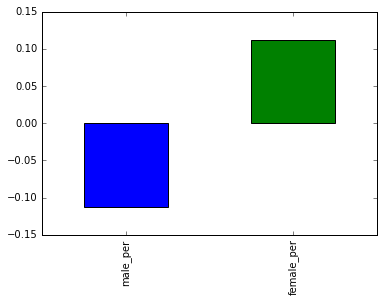

In [55]:
gender_corr.plot(kind='bar')

Gender doesn't seem to indicate anything

In [56]:
#investigate high performing girls schools
high_sat_high_female = combo.loc[(combo['sat_score']>1700)&(combo['female_per']>60),:]

In [57]:
high_sat_high_female

,index,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,rank_by_sat
4,302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,...,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25,5
6,5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,...,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01,7
9,26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,...,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02,10
10,60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,...,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03,11
12,61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,...,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03,13


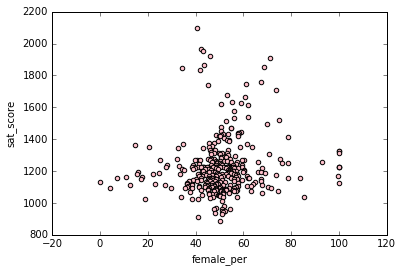

In [58]:
#the correlation between female percentage and score
combo.plot(kind='scatter', x='female_per', y='sat_score',c='pink')

some positive correlation. Most succesfull schools appear to have an even balance of boys and girls.


high performing 'girls schools' appear to be either selective, specialised or funded 

## Advanced placement 


Do schools with a higher percentage of AP test takers score better overall in the SAT exams?<br>


In [62]:
#percentage of students whom took AP
combo['app_per'] = combo['AP Test Takers ']/combo['total_enrollment']

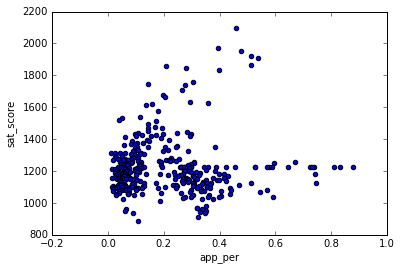

In [63]:
combo.plot(kind='scatter', x='app_per', y='sat_score')

Not a particulrly strong correlation between the percentage of ap entrance exam students within a school and the schools SAT score

## CONCLUSION
<br>
A very nice project to learn the fundamentals of combining data from various sources that also gave me an opportunity to use Basemap and other plotting tools.